# Coverage Analysis of rzpipe runs

Enumerating the sequencing coverage of the ribozyme library

# Importing Modules and Defining Functions

In [4]:
# Import Modules

import pandas as pd
import numpy as np
import pickle
import itertools

In [5]:
# Functions for printing DFs
def namevar(obj, namespace=globals()):
    '''
    namevar determines the name of the DF so you can print its name in printDF
    INPUT:
        an object
    OUPUT:
        name of the object
    '''
    return [name for name in namespace if namespace[name] is obj]

def printDF(DF,n=5):
    '''
    printDF prints the DF with the name of DF as an alternative to the html table print of DF
    DEPENDENCIES:
        requires namevar
    INPUT:
        DF
    
    OUPTUT:
        Prints with plenty of newlines and the title of the dataframe
    '''
    print('\n\n\n\n\n',namevar(DF),'\n\n',DF.head(n),'\n\n\n\n')

In [50]:
# Functions for reading files
def read_fasta(fname):
    '''
    read_fasta reads a fastqfile 2 lines at a time and records the seq_description 
    (ie header line, in this case the name of the library member)
    INPUT:
        a fasta file
    OUTPUT:
        returns a DF with no information, just indices corresponding to library member sequences 
    '''
    # Read .fasta file
    with open(fname, 'r') as fileH: 
        sequences = set() # non-redundant repository of sequences observed # Sets are faster
        for seq_description,seq_sequence in itertools.zip_longest(*[fileH]*2):
            sequences.add(seq_description[1:-1])
    DF = pd.DataFrame({'RNAME':list(sequences)})
    DF = DF.groupby(['RNAME']).sum() # Make sequences the indexs
    return (DF)

def read_tsv(bin_file_name, bin_number, condition):
    ''' 
    read_tsv reads the umi_tools group .tsv output-file and returns a DF with 
    INPUT: 
        1. bin_file_name - grouped.umi.tsv file 
        2. bin_number - what bin this file hails from
        3. what selection condition the bin was under
        
    OUTPUT: 
        binDF
            col 1 = 
        
        coverageDF
    
    '''
    # Read in file
    binDF = pd.read_csv(bin_file_name, usecols=[1,5],header=0, delimiter='\t')
    binDF.columns = ['RNAME','FINAL_UMI']
    binDF['UMI_COVERAGE'] = 1
    
    #  group by RNAME and FINAL_UMI
    binDF = binDF.groupby(['RNAME','FINAL_UMI']).sum().reset_index()
    
    # We need to figure out a cleaner way to report the proportion of UMIs containign Ns
#     normalized_nDF = binDF.fillna(np.NaN)
#     normalized_nDF['UMI_COVERAGE'] = 1
#     normalized_nDF_containN = normalized_nDF[normalized_nDF.FINAL_UMI.str.contains('N') == True ]
#     normalized_nDF_withoutN = normalized_nDF[normalized_nDF.FINAL_UMI.str.contains('N') == False]
#     print('Number of reads containing Ns in FINAL_UMI =',normalized_nDF_containN.UMI_COVERAGE.sum())
#     print('Number of reads withou     Ns in FINAL_UMI =',normalized_nDF_withoutN.UMI_COVERAGE.sum())

    # Move rows with FINAL_UMI containing Ns to another DF
    nDF   = binDF[binDF.FINAL_UMI.str.contains('N') == True ]
    binDF = binDF[binDF.FINAL_UMI.str.contains('N') == False]
#     print('Number of reads containing Ns in FINAL_UMI =',nDF.UMI_COVERAGE.sum())
#     print('Number of reads withou     Ns in FINAL_UMI =',binDF.UMI_COVERAGE.sum())
    

    # instantiate coverage DF
    coverageDF     = binDF.fillna(np.NaN) # avoid a situation where changing 1 DF will change the other 
    coverageDF['UMI_COVERAGE'] = 1

    # determine true coverage
    coverageDF = coverageDF.groupby(['RNAME']).sum()
    coverageDF = coverageDF.rename(columns={'UMI_COVERAGE':'LIBRARY_MEMBER_UMI_COVERAGE_'+condition})
    
    
    # Ascribe bin number, Calculate GC content
    coverageDF['BIN'] = 1
    coverageDF = coverageDF.reset_index()
    
    binDF['BIN']  = bin_number
    binDF['GC_CONTENT']    = binDF['FINAL_UMI'].apply(lambda FINAL_UMI: (FINAL_UMI.count('G') + FINAL_UMI.count('C'))/10)

    return(binDF, coverageDF)

In [7]:
# Functions for merging DFs
def cbind(colSourceDF, colDestinationDF, indexCol, cbindCol, debug=False):
    """
    cbind adds the column from one DF to another DF matching indices.
    INPUT: 
        colSourceDF - DF with column to be added to outputDF
        colDestinationDF - DF that the column will be added to
        indexCol - column in both colDestinationDF and colSourceDF that is used as index
        cbindCol - column to be bound
                 - if cbindCol = bind_all, the entire data frame will be concatenated
    OUTPUT:
        colDestinationDF is returned with columns bound and index reset
    """
    # Set indices of both columns
    colSourceDF      = colSourceDF     .set_index(indexCol)
    colDestinationDF = colDestinationDF.set_index(indexCol)
    
    # debug
    if debug == True:
        printDF(colSourceDF     , 'colSourceDF')
        printDF(colDestinationDF, 'colDestDF  ')
    
    # cbind
    if cbindCol == 'bind_all':
        colDestinationDF = pd.concat([colSourceDF, colDestinationDF], axis=1)
        
    else:
        colDestinationDF = pd.concat([colSourceDF[cbindCol], colDestinationDF], axis=1)
    
    # reset index to index col name
    colDestinationDF.index.name = indexCol
    # debug
    if debug == True:
        printDF(colSourceDF     , 'colSourceDF')
        printDF(colDestinationDF, 'colDestDF  ')
    
    colSourceDF      = colSourceDF     .reset_index()
    colDestinationDF = colDestinationDF.reset_index()

    # debug
    if debug == True:
        printDF(colSourceDF     , 'colSourceDF')
        printDF(colDestinationDF, 'colDestDF  ')
    
    return(colDestinationDF)

# Input Files

In [59]:
aptamer = '804'

# Define sub directory
homeDir      = '../171103-coverage-analysis-nextseq/'
inputHomeDir = homeDir+aptamer+'/umi-files'

# 8 bins P+S- fnames
bin1_neg = inputHomeDir+'/'+aptamer+"-PpSm1.tsv"
bin2_neg = inputHomeDir+'/'+aptamer+"-PpSm2.tsv"
bin3_neg = inputHomeDir+'/'+aptamer+"-PpSm3.tsv"
bin4_neg = inputHomeDir+'/'+aptamer+"-PpSm4.tsv"
bin5_neg = inputHomeDir+'/'+aptamer+"-PpSm5.tsv"
bin6_neg = inputHomeDir+'/'+aptamer+"-PpSm6.tsv"
bin7_neg = inputHomeDir+'/'+aptamer+"-PpSm7.tsv"
bin8_neg = inputHomeDir+'/'+aptamer+"-PpSm8.tsv" 

## 8 bins P+S+ fnames
#bin1_pos = inputHomeDir+aptamer+"-PpSp1.tsv"
#bin2_pos = inputHomeDir+aptamer+"-PpSp2.tsv"
#bin3_pos = inputHomeDir+aptamer+"-PpSp3.tsv"
#bin4_pos = inputHomeDir+aptamer+"-PpSp4.tsv"
#bin5_pos = inputHomeDir+aptamer+"-PpSp5.tsv"
#bin6_pos = inputHomeDir+aptamer+"-PpSp6.tsv"
#bin7_pos = inputHomeDir+aptamer+"-PpSp7.tsv"
#bin8_pos = inputHomeDir+aptamer+"-PpSp8.tsv"

# Library fnames (for loading all possible sequences)
twist_library = homeDir+"/reference-libraries-fasta/famin811-stem_apt.fasta"
novel_library = homeDir+"/reference-libraries-fasta/..."

# Read in *.fasta* library and *.tsv* sequencing data

In [23]:
# Create DF from both .fasta libraries
twistLibDF        = read_fasta(twist_library)
#novelMembersLibDF = read_fasta(novel_library)

# Concat expected (twistDF) and unexpected (novelMembersLibDF) into one library
#libraryDF = pd.concat([twistLibDF, unmappedLibDF])

libraryDF = twistLibDF

In [24]:
libraryDF

""
RNAME
AAAAA...TTTTT
AAAAC...GTTTT
AAAAG...CTTTT
AAAAG...TTTTT
AAAAT...ATTTT
AAAAT...GTTTT
AAACA...TGTTT
AAACC...GGTTT
AAACG...CGTTT


In [60]:
# Load binX.sam files
# bin1_posDF, bin1_pos_coverageDF = read_tsv(bin1_pos, bin_number=1, condition='POS')
# bin2_posDF, bin2_pos_coverageDF = read_tsv(bin2_pos, bin_number=2, condition='POS')
# bin3_posDF, bin3_pos_coverageDF = read_tsv(bin3_pos, bin_number=3, condition='POS')
# bin4_posDF, bin4_pos_coverageDF = read_tsv(bin4_pos, bin_number=4, condition='POS')
# bin5_posDF, bin5_pos_coverageDF = read_tsv(bin5_pos, bin_number=5, condition='POS')
# bin6_posDF, bin6_pos_coverageDF = read_tsv(bin6_pos, bin_number=6, condition='POS')
# bin7_posDF, bin7_pos_coverageDF = read_tsv(bin7_pos, bin_number=7, condition='POS')
# bin8_posDF, bin8_pos_coverageDF = read_tsv(bin8_pos, bin_number=8, condition='POS')

bin1_negDF, bin1_neg_coverageDF = read_tsv(bin1_neg, bin_number=1, condition='NEG')
bin2_negDF, bin2_neg_coverageDF = read_tsv(bin2_neg, bin_number=2, condition='NEG')
bin3_negDF, bin3_neg_coverageDF = read_tsv(bin3_neg, bin_number=3, condition='NEG')
bin4_negDF, bin4_neg_coverageDF = read_tsv(bin4_neg, bin_number=4, condition='NEG')
bin5_negDF, bin5_neg_coverageDF = read_tsv(bin5_neg, bin_number=5, condition='NEG')
bin6_negDF, bin6_neg_coverageDF = read_tsv(bin6_neg, bin_number=6, condition='NEG')
bin7_negDF, bin7_neg_coverageDF = read_tsv(bin7_neg, bin_number=7, condition='NEG')
bin8_negDF, bin8_neg_coverageDF = read_tsv(bin8_neg, bin_number=8, condition='NEG')

In [52]:
bin1_negDF

,RNAME,FINAL_UMI,UMI_COVERAGE,BIN,GC_CONTENT
0,AAAAA...TTTTT,CTTTACGTTA,1,1,0.3
1,AAAAG...TTTTT,AAGTCCCCAT,2878,1,0.5
2,AAAAG...TTTTT,AGCTTTTTGT,1,1,0.3
3,AAAAG...TTTTT,ATTCTCTCGC,1,1,0.5
5,AAAAG...TTTTT,TGTCAAGTGT,1,1,0.4
6,AAAAG...TTTTT,TTATGTCCTT,1,1,0.3
7,AAACA...TGTTT,CAGCCACATG,1903,1,0.6
9,AAACA...TGTTT,CTACTATATC,262,1,0.3
10,AAACA...TGTTT,CTAGCTACGG,1,1,0.6
11,AAACA...TGTTT,CTCCTAAAAG,1913,1,0.4


In [46]:
bin1_neg_coverageDF

,RNAME,LIBRARY_MEMBER_UMI_COVERAGE_NEG,BIN
0,AAAAA...TTTTT,1,1
1,AAAAG...TTTTT,5,1
2,AAACA...TGTTT,7,1
3,AAACC...GGTTT,3,1
4,AAACG...CGTTT,1,1
5,AAACG...TGTTT,1,1
6,AAACT...AGTTT,1,1
7,AAAGC...GCTTT,1,1
8,AAAGC...GTTTT,1,1
9,AAAGG...TCTTT,1,1


In [61]:
# Concatenate bins
#binspreadDFpos = pd.concat(   [   \
#                bin1_posDF,\
#                bin2_posDF,\
#                bin3_posDF,\
#                bin4_posDF,\
#                bin5_posDF,\
#                bin6_posDF,\
#                bin7_posDF,\
#                bin8_posDF ], ignore_index=True    )
binspreadDFpos = pd.DataFrame()



binspreadDFneg = pd.concat(   [   \
                bin1_negDF,\
                bin2_negDF,\
                bin3_negDF,\
                bin4_negDF,\
                bin5_negDF,\
                bin6_negDF,\
                bin7_negDF,\
                bin8_negDF   ], ignore_index=True   )

#coverageDFpos = pd.concat([\
#    bin1_pos_coverageDF,\
#    bin2_pos_coverageDF,\
#    bin3_pos_coverageDF,\
#    bin4_pos_coverageDF,\
#    bin5_pos_coverageDF,\
#    bin6_pos_coverageDF,\
#    bin7_pos_coverageDF,\
#    bin8_pos_coverageDF ])
covrageDFpos = pd.DataFrame()

coverageDFneg = pd.concat([\
    bin1_neg_coverageDF,\
    bin2_neg_coverageDF,\
    bin3_neg_coverageDF,\
    bin4_neg_coverageDF,\
    bin5_neg_coverageDF,\
    bin6_neg_coverageDF,\
    bin7_neg_coverageDF,\
    bin8_neg_coverageDF ])

In [63]:
len(binspreadDFneg)

596413

In [64]:
# Calculate bin mean and median for neg
statsDFneg = binspreadDFneg.loc[:,['RNAME','BIN']].groupby('RNAME',as_index=False).mean()
statsDFneg.columns = ['RNAME','BIN_MEAN_NEG']
statsDFneg['BIN_MEDIAN_NEG'] = binspreadDFneg.loc[:,['RNAME','BIN']].groupby('RNAME',as_index=False).median()['BIN']

In [65]:
# Sum counts for sample size DFs
#coverageDFpos = coverageDFpos.loc[:,['RNAME','LIBRARY_MEMBER_UMI_COVERAGE_POS']].groupby('RNAME', as_index=False).sum()
coverageDFneg = coverageDFneg.loc[:,['RNAME','LIBRARY_MEMBER_UMI_COVERAGE_NEG']].groupby('RNAME', as_index=False).sum()

In [66]:
# coverageDF = pd.concat([coverageDFpos, coverageDFneg], axis=0)
coverageDF = pd.concat([ coverageDFneg], axis=0)
coverageDF = coverageDF.groupby('RNAME',as_index=False).sum()

In [69]:
len(coverageDF)

7776

In [ ]:
#statsDF = cbind(colSourceDF = statsDFpos,\
#                colDestinationDF = statsDFneg,\
#                indexCol = 'RNAME',\
#                cbindCol = 'bind_all')

statsDF = statsDFneg

In [ ]:
statsDF = cbind(colSourceDF      = coverageDF,\
                colDestinationDF = statsDF,\
                indexCol         = 'RNAME',\
                cbindCol         = 'LIBRARY_MEMBER_UMI_COVERAGE_NEG')

# Plotting Coverage Analysis

In [54]:
%load_ext rpy2.ipython
%R library(ggplot2)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


array(['ggplot2', 'tools', 'stats', 'graphics', 'grDevices', 'utils',
       'datasets', 'methods', 'base'], 
      dtype='<U9')

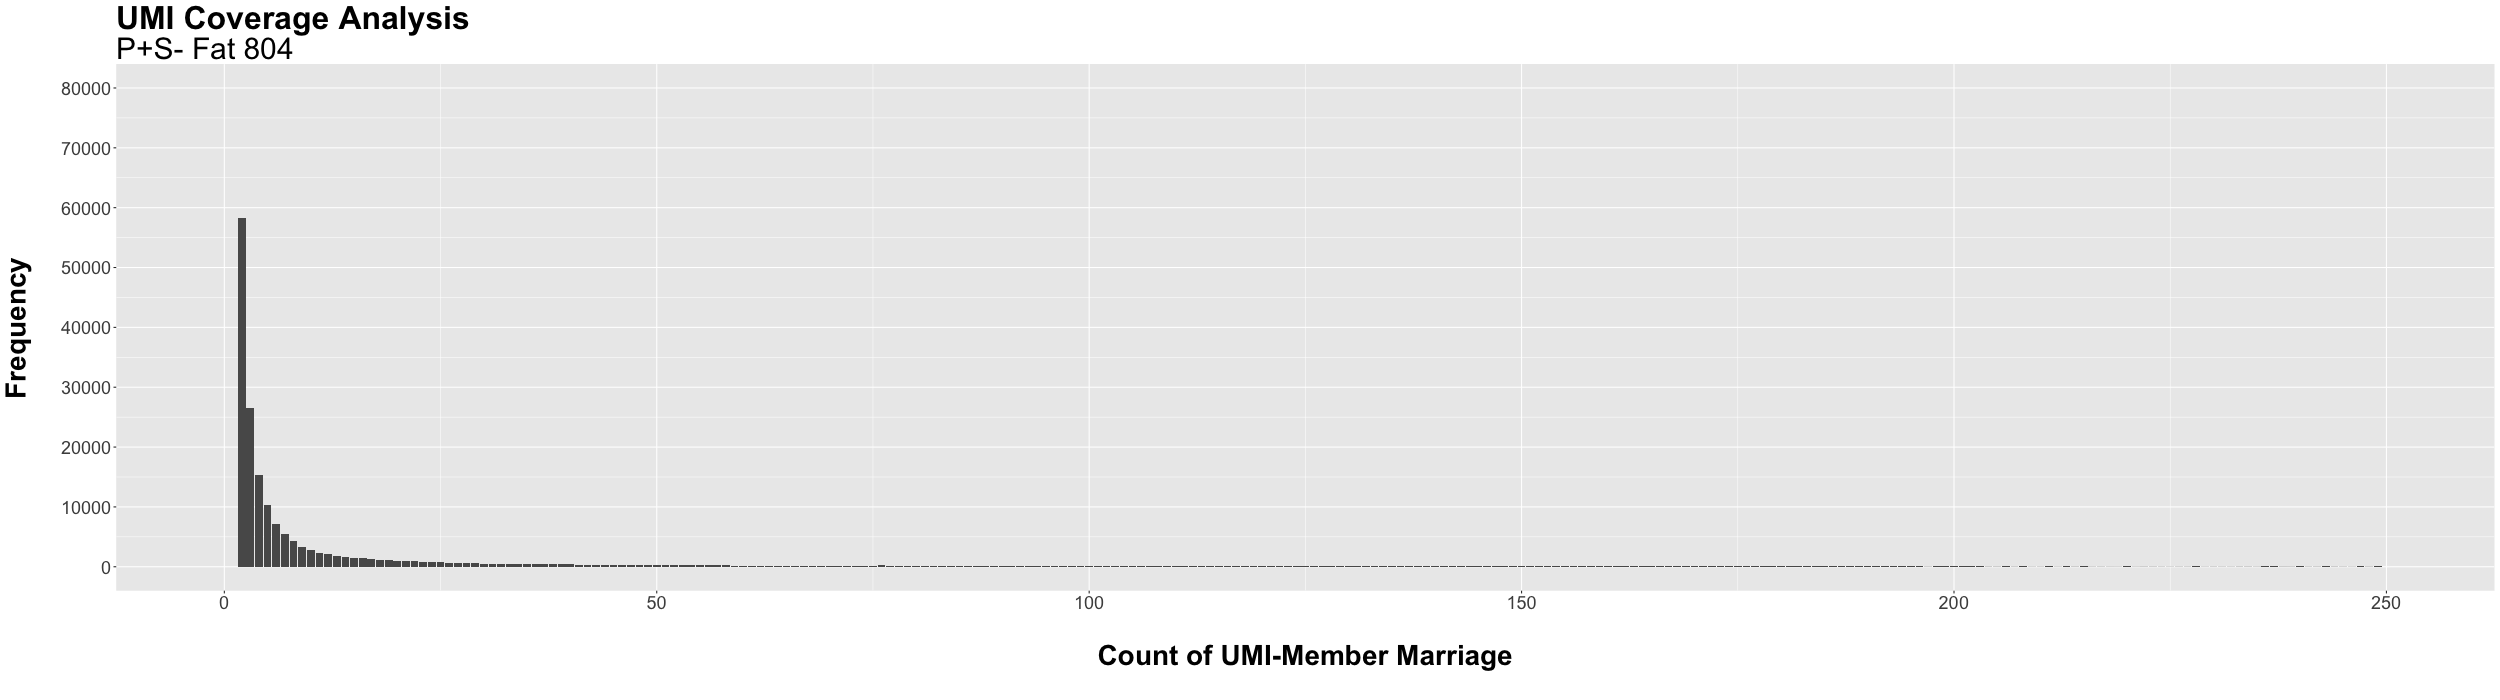

In [73]:
%%R -i binspreadDFneg -i aptamer -w 2500 -h 700 -u px

ggplot(binspreadDFneg, aes(x=UMI_COVERAGE)) +
    geom_histogram(stat='count',binwidth = 1) +
    labs(title="UMI Coverage Analysis",
         subtitle=paste('P+S- Fat ',aptamer,sep=''),
         x="\nCount of UMI-Member Marriage\n", 
         y="Frequency\n") +
    xlim(c(0,250)) +
    scale_y_continuous(breaks = seq(0,100000, by = 10000),limits=c(0,80000)) +
    theme(axis.text=element_text(size=18),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=30),
        plot.caption=element_text(size=12),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

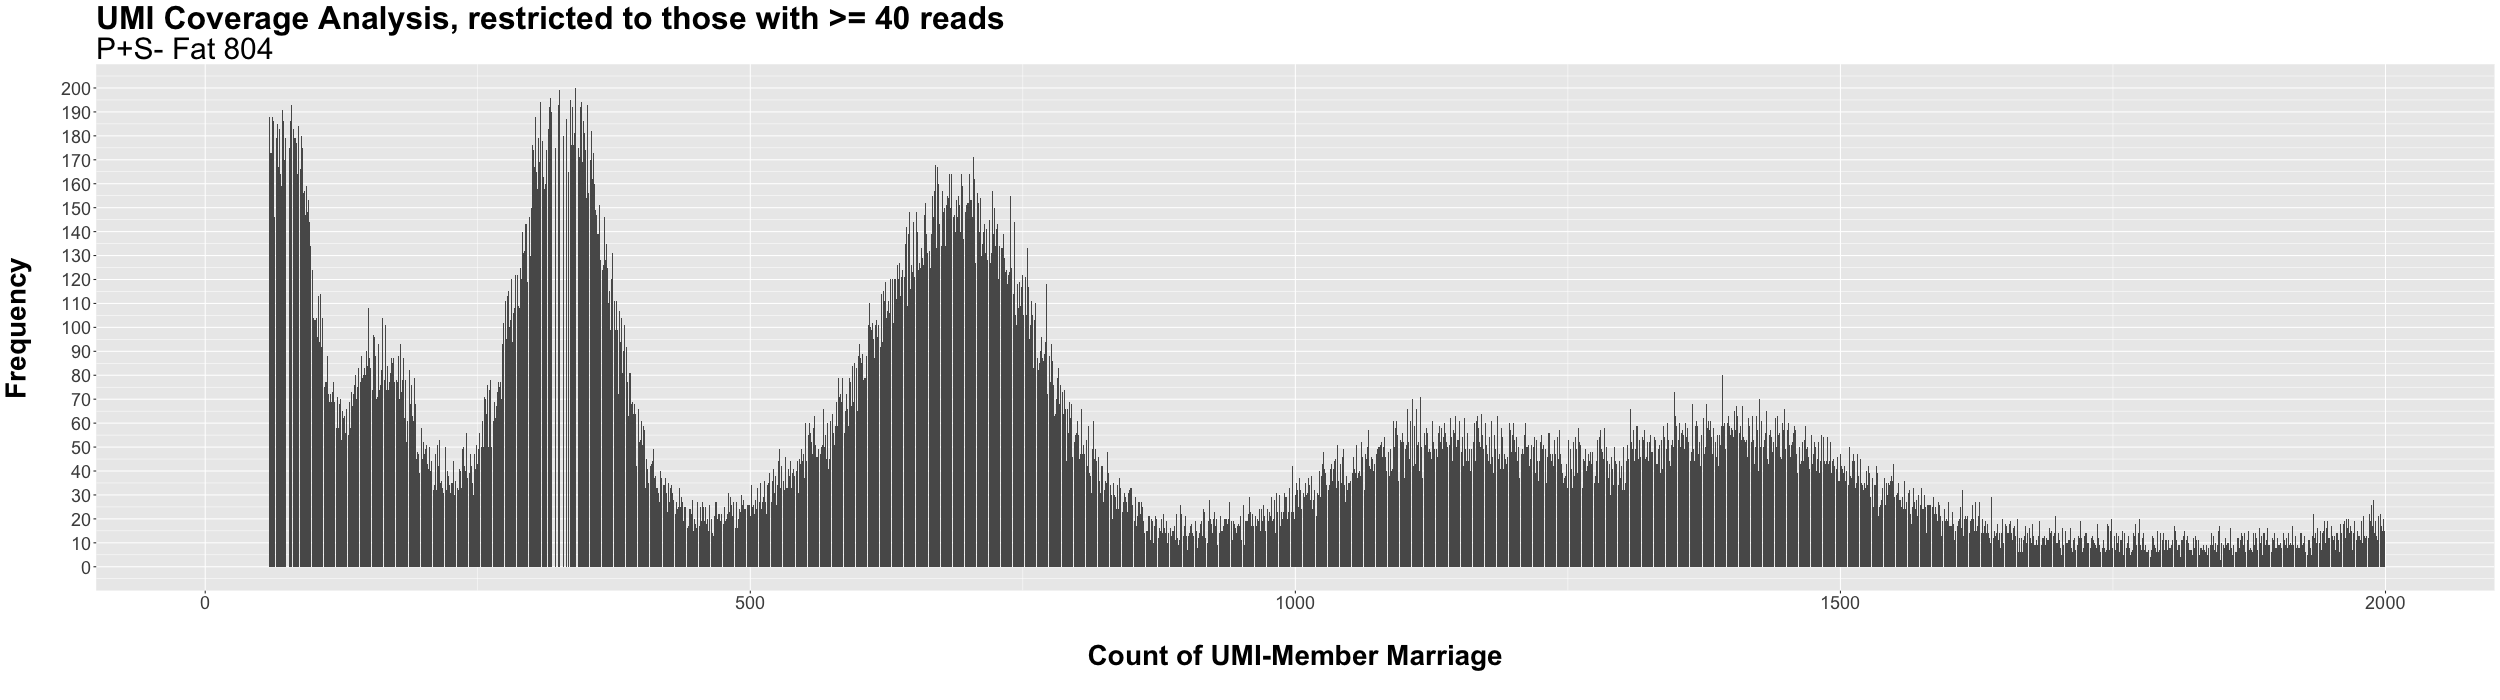

In [83]:
%%R -i binspreadDFneg -i aptamer -w 2500 -h 700 -u px

ggplot(binspreadDFneg[binspreadDFneg$UMI_COVERAGE >=40,], aes(x=UMI_COVERAGE)) +
    geom_histogram(stat='count',binwidth = 1) +
    labs(title="UMI Coverage Analysis, restricted to those with >= 40 reads",
         subtitle=paste('P+S- Fat ',aptamer,sep=''),
         x="\nCount of UMI-Member Marriage\n", 
         y="Frequency\n") +
    xlim(c(0,2000)) +
    scale_y_continuous(breaks = seq(0,200, by = 10),limits=c(0,200)) +
    theme(axis.text=element_text(size=18),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=30),
        plot.caption=element_text(size=12),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))

In [ ]:
# Soon- cluster based on sequence similarity, UMI similarity, combo; color seq+UMI marriages
# that are in the same normal distribution in the above graph, in same color


In [86]:
# Write in python!
%%R -i binspreadDFneg -i aptamer -w 2500 -h 700 -u px
library(stringr)
f = function(seq){
    seq = as.character(seq)
    return((str_count(seq, "G")+str_count(seq, "C"))/nchar(seq))
}

possible_clust1 = binspreadDFneg[binspreadDFneg>= 500 & binspreadDFneg<=800,]
possible_clust1$GC_seq = lapply(possible_clust1$RNAME, FUN=f)
print(mean(possible_clust1$GC_seq))
print(sd(possible_clust1$GC_seq))

[1] NA
Error: is.atomic(x) is not TRUE


/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error: is.atomic(x) is not TRUE

  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: 
  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In Ops.factor(left, right) :
  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  ‘>=’ not meaningful for factors

  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: 
  warnings.warn(x, RRuntimeWarn

In [74]:
binspreadDFneg

,RNAME,FINAL_UMI,UMI_COVERAGE,BIN,GC_CONTENT
0,AAAAA...TTTTT,CTTTACGTTA,1,1,0.3
1,AAAAG...TTTTT,AAGTCCCCAT,2878,1,0.5
2,AAAAG...TTTTT,AGCTTTTTGT,1,1,0.3
3,AAAAG...TTTTT,ATTCTCTCGC,1,1,0.5
4,AAAAG...TTTTT,TGTCAAGTGT,1,1,0.4
5,AAAAG...TTTTT,TTATGTCCTT,1,1,0.3
6,AAACA...TGTTT,CAGCCACATG,1903,1,0.6
7,AAACA...TGTTT,CTACTATATC,262,1,0.3
8,AAACA...TGTTT,CTAGCTACGG,1,1,0.6
9,AAACA...TGTTT,CTCCTAAAAG,1913,1,0.4


In [78]:
lessThan40 = len(binspreadDFneg[binspreadDFneg['UMI_COVERAGE']<=40])
print(lessThan40/len(binspreadDFneg))

0.7759187006319447


/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning:
  warnings.warn(x, RRuntimeWarning)
/Users/josephsolvason/miniconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning:  Ignoring unknown parameters: binwidth, bins, pad

  warnings.warn(x, RRuntimeWarning)


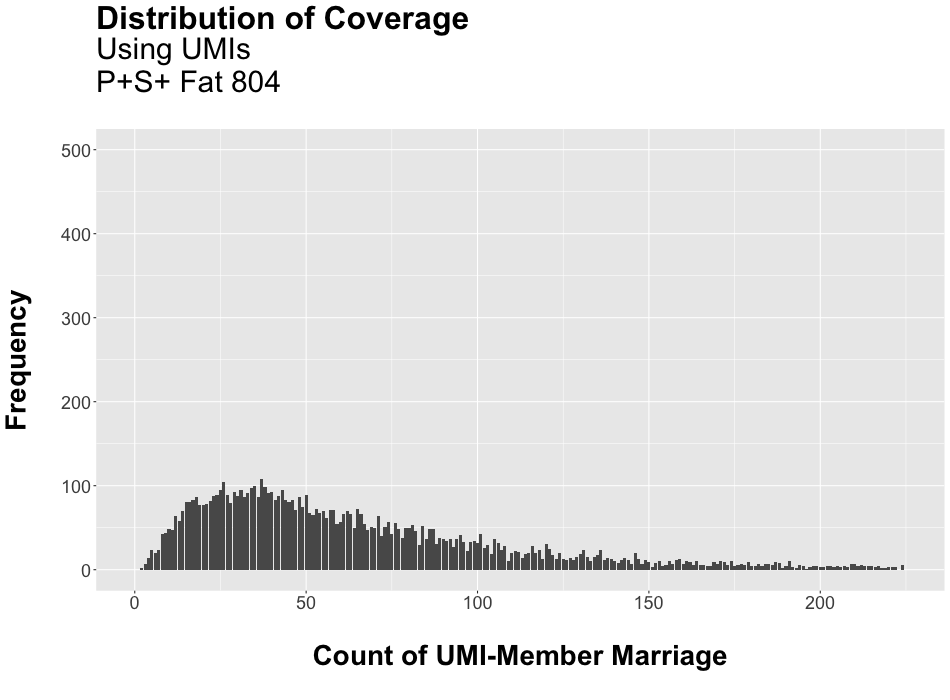

In [68]:
%%R -i coverageDFneg -i aptamer -w 950 -h 700 -u px

ggplot(coverageDFneg, aes(x=LIBRARY_MEMBER_UMI_COVERAGE_NEG)) +
    geom_histogram(stat='count',binwidth = 1) +
    labs(title="Distribution of Coverage",
         subtitle=paste('Using UMIs\nP+S+ Fat ',aptamer,'\n',sep=''),
         x="\nCount of UMI-Member Marriage\n", 
         y="Frequency\n") +
    xlim(c(0,225)) +
    scale_y_continuous(breaks = seq(0,100000, by = 100),limits=c(0,500)) +
    theme(axis.text=element_text(size=18),
        axis.title=element_text(size=28,face="bold"),
        plot.title=element_text(size=32,face="bold"),
        plot.subtitle=element_text(size=30),
        plot.caption=element_text(size=12),
        legend.title=element_text(size=17),
        legend.text=element_text(size=12))